here i will train a new mlp on pseudo + synth data

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import pandas as pd
from tensorflow import keras
from sklearn.manifold import TSNE
import os
from collections import Counter

#### prepare the data ( so the data would be pseudo + synth)

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# 1) Directory containing your merged .npz per class
dir_q = 'vae_mlp_2 models/synthetic_plus_pseudo'

# 2) Discover all .npz files
files = [f for f in os.listdir(dir_q) if f.endswith('.npz')]
print(f"Found {len(files)} class files in {dir_q}\n")

# 3) Load each, record counts, and build X_all, y_all
X_list = []
y_list = []
class_counts = {}

for fname in sorted(files):
    path = os.path.join(dir_q, fname)
    # assume filename like "class_3_plus_synth.npz" or "class_3.npz"
    # extract the first integer you find in the filename
    import re
    m = re.search(r'(\d+)', fname)
    if not m:
        print(f"Skipping {fname}: no class index found")
        continue
    cls = int(m.group(1))

    data = np.load(path)
    # your arrays are saved under key 'X' or 'arr_0'
    X = data.get('X', data.get('arr_0'))
    n = X.shape[0]
    class_counts[cls] = n

    print(f"Class {cls:2d} → {n:6d} sequences loaded from {fname}")

    X_list.append(X)
    y_list.append(np.full(n, cls, dtype=np.int32))

# 4) Concatenate into full dataset
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
total = X_all.shape[0]
print(f"\nTotal sequences across all classes: {total}\n")

# 5) Stratified train/validation split (80/20)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print(f"After 80/20 split:")
print(f"  Training set:   X_tr={X_tr.shape}, y_tr={y_tr.shape}")
print(f"  Validation set: X_val={X_val.shape}, y_val={y_val.shape}\n")

# 6) Report per-class counts in each split
print("Per-class counts:")
classes = sorted(class_counts.keys())
print(f"{'Class':>5s} | {'Total':>6s} | {'Train':>6s} | {'Val':>6s}")
print("-" * 32)
for cls in classes:
    total_c = class_counts[cls]
    train_c = np.sum(y_tr == cls)
    val_c   = np.sum(y_val == cls)
    print(f"{cls:5d} | {total_c:6d} | {train_c:6d} | {val_c:6d}")

# 7) Save splits to .npz
out_path = os.path.join('vae_mlp_2 models/final_training_data', 'train_val_split.npz')
np.savez_compressed(
    out_path,
    X_train=X_tr,
    y_train=y_tr,
    X_val=X_val,
    y_val=y_val
)
print(f"\nSaved train/val splits to {out_path}")


Found 15 class files in vae_mlp_2 models/synthetic_plus_pseudo

Class  0 →    100 sequences loaded from class_0.npz
Class  1 →     80 sequences loaded from class_1.npz
Class 10 →    510 sequences loaded from class_10.npz
Class 11 →    257 sequences loaded from class_11.npz
Class 12 →    100 sequences loaded from class_12.npz
Class 13 →   1050 sequences loaded from class_13.npz
Class 14 →     80 sequences loaded from class_14.npz
Class  2 →    250 sequences loaded from class_2.npz
Class  3 →    168 sequences loaded from class_3.npz
Class  4 →    214 sequences loaded from class_4.npz
Class  5 →    350 sequences loaded from class_5.npz
Class  6 →    310 sequences loaded from class_6.npz
Class  7 →    510 sequences loaded from class_7.npz
Class  8 →     80 sequences loaded from class_8.npz
Class  9 →     30 sequences loaded from class_9.npz

Total sequences across all classes: 4089

After 80/20 split:
  Training set:   X_tr=(3271, 263, 21), y_tr=(3271,)
  Validation set: X_val=(818, 263, 2

In [ ]:
# to load
# 1) Load your train/val split
data = np.load('vae_mlp_2/models/synthetic_plus_pseudo/train_val_split.npz')
X_tr, y_tr = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']

print(f"X_tr shape: {X_tr.shape}, y_tr shape: {y_tr.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

### read fasta stuff

In [2]:
def read_fasta(input_f):
    sequences = []
    current_seq = ""
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ""
            else:
                current_seq += line
        if current_seq:
            sequences.append(current_seq)
    return sequences

def select_random_sequences(sequences, num_samples=10000):
    if len(sequences) < num_samples :
        raise ValueError("The number of requested sequences exceeds the initial list size.")

    return random.sample(sequences, num_samples)


def encode_sequences_one_hot_with_gap(sequences, max_length=None) :

    amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}
    valid_sequences = [seq for seq in sequences if all(aa in aa_to_idx for aa in seq)]

    if not valid_sequences :  # Return empty array if no valid sequences remain
        return np.array([])

    # Set maximum length
    if max_length is None :
        max_length = max(len(seq) for seq in valid_sequences)

    # Initialize the output matrix with zeros
    M = len(valid_sequences)
    L = max_length
    encoded_matrix = np.zeros((M, L, len(amino_acids)), dtype=np.float32)

    # Encode each sequence
    for i, seq in enumerate(valid_sequences) :
        for j, aa in enumerate(seq[:max_length]) :  # Truncate sequences longer than max_length
            encoded_matrix[i, j, aa_to_idx[aa]] = 1.0  # One-hot encode valid amino acids and gaps
    return encoded_matrix

### vae model

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a sequence."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Encodes sequences into latent space."""
    
    def __init__(self, latent_dim, intermediate_dims=[256, 128, 64], **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    """Decodes a latent space point into a sequence."""
    
    def __init__(self, original_dim, intermediate_dims=[64, 128, 256], **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.dense_output(x)

class VAE(Model):
    """Variational Autoencoder for protein sequences."""
    
    def __init__(self, original_dim, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Scale KL loss by input dimension to balance it with reconstruction loss
        kl_loss = kl_loss * (1.0 / self.original_dim)
        
        self.add_loss(kl_loss)
        return reconstructed
    
    def encode(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return z_mean, z_log_var, z
    
    def decode(self, z):
        return self.decoder(z)
    
    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'latent_dim': self.latent_dim
        })
        return config
    

# Rebuild the model architecture
vae = VAE(original_dim=5523, latent_dim=32)

dummy_input = np.zeros((1, 5523), dtype=np.float32)  # Match input shape
_ = vae(dummy_input)  # Force layer creation

vae.load_weights('models/200000seq_best_vae_model.h5')  # Load weights

vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     1,461,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     1,464,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,907 (11.16 MB)

 Trainable params: 2,924,115 (11.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

### freez the encoder

In [6]:
# build a standalone encoder that outputs only z_mean
# 1) One‑hot 3D input
inp_3d = layers.Input(shape=(263, 21), name='onehot_input')

# 2) Flatten to the original_dim your VAE expects
flat   = layers.Flatten(name='flatten')(inp_3d)

# 3) Call encode() without the training kwarg
z_mean, z_logvar, z = vae.encode(flat)

# 4) Build the encoder model
encoder = Model(inputs=inp_3d, outputs=z_mean, name='encoder_3d_to_32')
encoder.summary()

Model: "encoder_3d_to_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ onehot_input (InputLayer)       │ (None, 263, 21)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5523)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Encoder)               │ [(None, 32), (None,    │     1,461,248 │
│                                 │ 32), (None, 32)]       │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,461,248 (5.57 MB)

 Trainable params: 1,460,352 (5.57 MB)

 Non-trainable params: 896 (3.50 KB)

#### embeding labeled data via 3D→32 encoder
we are not changing encoder weights, we just want to have 32 dim vectors of our data in latent space.
our model is not expose and not learning our labled data

In [7]:
# 2) Choose embedding batch size
batch_size = 64

# 3) If you're using the standalone encoder model (3D → 32):
encoder.trainable = False

Z_tr  = encoder.predict(X_tr,  batch_size=batch_size, verbose=1)  # → (n_train, 32)
Z_val = encoder.predict(X_val, batch_size=batch_size, verbose=1)  # → (n_val,   32)

print("Latent shapes:", Z_tr.shape, Z_val.shape)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Latent shapes: (3271, 32) (818, 32)


### train mlp on tr/val data

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

input_dim   = Z_tr.shape[1]
num_classes = len(np.unique(y_tr))

clf = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='latent_mlp')

clf.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = clf.fit(
    Z_tr, y_tr,
    validation_data=(Z_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

# 4) Evaluate on validation splits
val_loss, val_acc = clf.evaluate(Z_val, y_val, verbose=0)
print(f"\nValidation accuracy: {val_acc:.2%}")

from sklearn.metrics import classification_report
# 5) Detailed classification report
y_pred = np.argmax(clf.predict(Z_val), axis=1)
print("\nClassification report on validation set:")
print(classification_report(y_val, y_pred, digits=4))


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2217 - loss: 2.4312 - val_accuracy: 0.7726 - val_loss: 1.3337
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7281 - loss: 1.2257 - val_accuracy: 0.8374 - val_loss: 0.7752
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8340 - loss: 0.7617 - val_accuracy: 0.8765 - val_loss: 0.5330
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8689 - loss: 0.5668 - val_accuracy: 0.9193 - val_loss: 0.3987
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9043 - loss: 0.4316 - val_accuracy: 0.9364 - val_loss: 0.3157
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9074 - loss: 0.3684 - val_accuracy: 0.9462 - val_loss: 0.2634
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9211 - loss: 0.3233 - val_accuracy: 0.9499 - val_loss: 0.2219
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9396 - loss: 0.2628 - val_accu

### test data

In [11]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- 1) Rebuild label_counts & label_to_idx from your FASTA folder ---
data_dir = "hmm_20"
suffix   = "_noInserts_noGaps_noDuplicates"

label_counts = {}
all_seqs     = []
all_labels   = []

for fname in os.listdir(data_dir):
    if not fname.lower().endswith('.fasta'):
        continue
    base = os.path.splitext(fname)[0]
    label = base[:-len(suffix)] if base.endswith(suffix) else base

    path = os.path.join(data_dir, fname)
    seqs = read_fasta(path)                 # your FASTA reader
    label_counts[label] = len(seqs)
    all_seqs.extend(seqs)
    all_labels.extend([label] * len(seqs))

# Now create a consistent sorted mapping
unique_labels = sorted(label_counts.keys())
label_to_idx  = {lbl: i for i, lbl in enumerate(unique_labels)}

print("Rebuilt label_counts and label_to_idx:")
for lbl, idx in label_to_idx.items():
    print(f"  {lbl:50s} → {idx}")

# --- 2) Filter out invalid sequences ---
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
aa_to_idx   = {aa: i for i, aa in enumerate(amino_acids)}

valid_idxs = [i for i, seq in enumerate(all_seqs)
              if all(ch in aa_to_idx for ch in seq)]

filtered_seqs   = [all_seqs[i]       for i in valid_idxs]
filtered_labels = [all_labels[i]     for i in valid_idxs]

# Convert labels to integers
y_test = np.array([label_to_idx[lbl] for lbl in filtered_labels], dtype=np.int32)
print(f"\nAfter filtering: {len(filtered_seqs)} valid sequences, y_test shape: {y_test.shape}")

# --- 3) One-hot encode into shape (N, 263, 21) ---
X_test = encode_sequences_one_hot_with_gap(filtered_seqs, max_length=263)
print(f"X_test shape: {X_test.shape}")

Rebuilt label_counts and label_to_idx:
  CBL_interacting_protein_kinases                    → 0
  L_type_lectin_kinases                              → 1
  aurora_kinases                                     → 2
  cAMP_dependent_protein_kinases                     → 3
  calcium_calmodulin_dependent_kinases               → 4
  calcium_dependent_kinases                          → 5
  casein_kinases                                     → 6
  cyclin_dependent_kinases                           → 7
  dual_specificity_protein_kinases                   → 8
  eukaryotic_translation_initiation_factor_kinases   → 9
  mitogen_activated_kinases                          → 10
  protein_kinases                                    → 11
  ribosomal_protein_S6_kinases                       → 12
  serine_threonine_kinases                           → 13
  tyrosine_kinases                                   → 14

After filtering: 1757 valid sequences, y_test shape: (1757,)
X_test shape: (1757, 263, 21)


In [12]:
# --- 4) Embed via your encoder ---
# If you have a standalone encoder model:
Z_test = encoder.predict(X_test, batch_size=64, verbose=1)
# Or, using vae.encode:
# X_flat = X_test.reshape(X_test.shape[0], -1)
# z_mean, _, _ = vae.encode(X_flat)
# Z_test = z_mean.numpy()

print(f"Z_test shape: {Z_test.shape}")

# --- 5) Predict & evaluate using your trained classifier ---
y_pred = np.argmax(clf.predict(Z_test, batch_size=64, verbose=1), axis=1)

acc = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {acc:.2%}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Z_test shape: (1757, 32)
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Test accuracy: 82.13%

Confusion matrix:
[[ 29   0   0   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0  12   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  31   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0  26   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0  30   0   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0   0  78   0   0   0   0   0   1   0   1   0]
 [  0   0   0   0   0   0  30   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0 170   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0  15   0   1   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   6   0   0   0   2   0]
 [  0   0   0   0   0   0   0   7   1   0 207   0   0  39   0]
 [  0   0   0   0   0   0   1   4   0   0   2  49   0  21   1]
 [  0   0   0   0   0   0   0   0   0   0   0   1  21   1   0]
 [ 47   0   2  13  13   5   8  53  

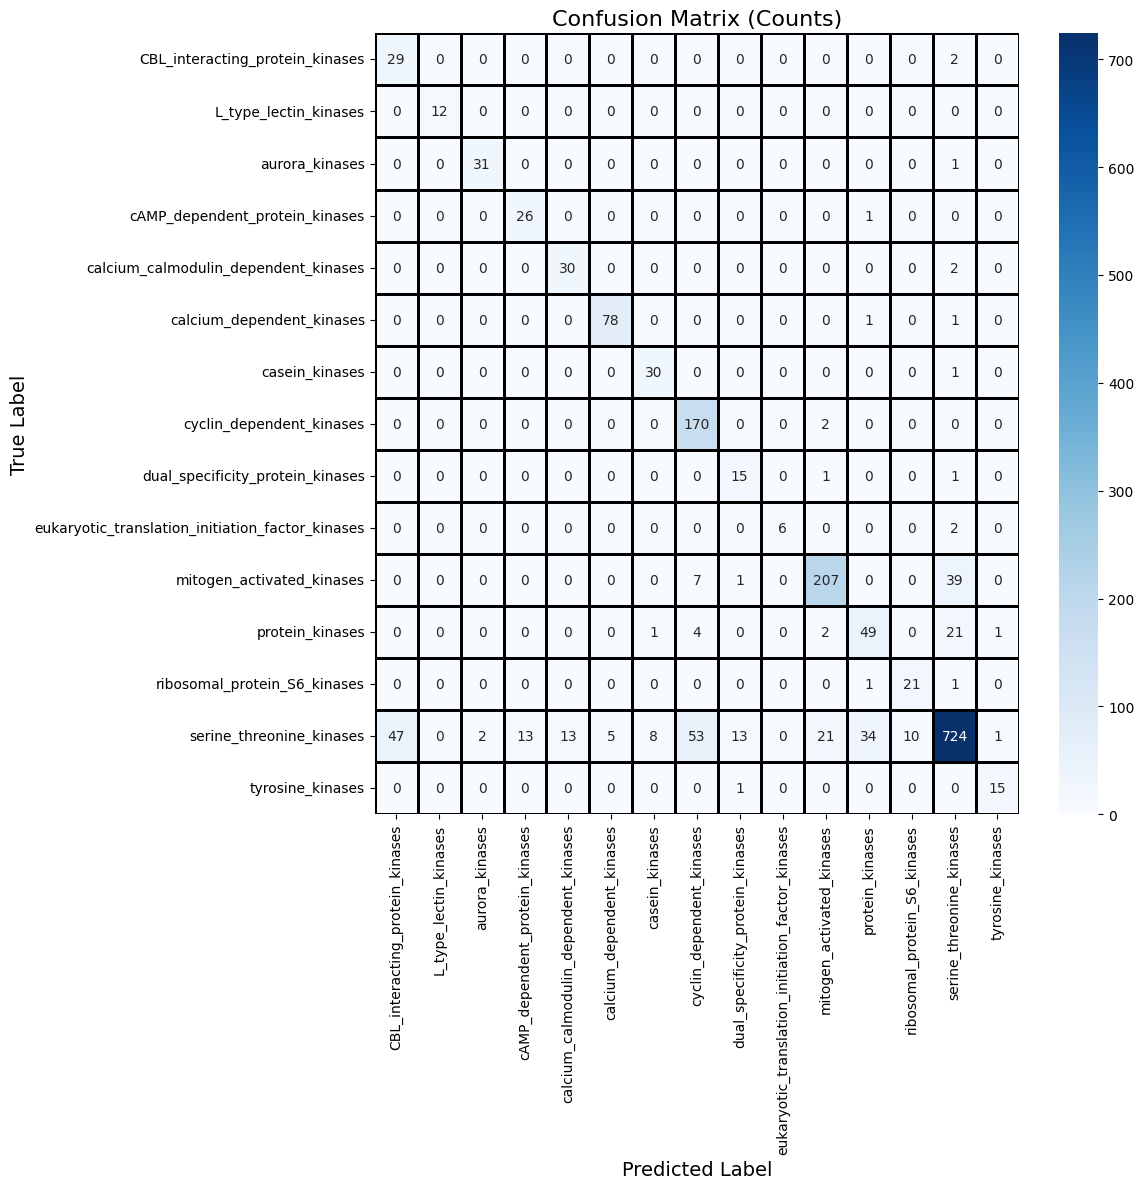

In [25]:
import seaborn as sns
# 2) Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2) Wrap in a DataFrame for nicer indexing
df_cm = pd.DataFrame(cm,
                     index=unique_labels,
                     columns=unique_labels)

# 3) Plot
plt.figure(figsize=(12, 12))
sns.heatmap(
    df_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0.8,
    linecolor='black',
    xticklabels=unique_labels,
    yticklabels=unique_labels
)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (Counts)', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


#### save the model & how to load

In [13]:
# this writes a directory “encoder_3d_to_32” in TensorFlow’s SavedModel format
encoder.save('vae_mlp_3 models/encoder_3d_to_32.keras')
clf.save('vae_mlp_3 models/latent_mlp_classifier.keras')
vae.save('vae_mlp_3 models/protein_vae_model.keras')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# from your_module import Sampling, Encoder, Decoder, VAE  # if you need them

# 1) Re-load encoder
encoder = load_model(
    'vae_mlp_2 models/encoder_3d_to_32.keras',
    custom_objects={'Sampling': Sampling,
                    'Encoder': Encoder}
)

# 2) Re-load classifier
clf = load_model('vae_mlp_2 models/latent_mlp_classifier.keras')

"""
# 3) (Optional) Re-load full VAE
vae = load_model(
    'vae_mlp_2 models/protein_vae_model.keras',
    custom_objects={'Sampling': Sampling, 'Encoder': Encoder, 'Decoder': Decoder, 'VAE': VAE}
)
"""

### AGAIN, pseudo labeling to augment labled data

In [27]:
seq_list = read_fasta('PF00069_noinserts_gaps_noduplicates.fasta')

In [28]:
batch1 = seq_list[:100000]

In [42]:
batch2 = seq_list[100000:200000]

In [46]:
batch3 = seq_list[200000:300000]

In [50]:
batch4 = seq_list[300000:400000]

In [54]:
batch5 = seq_list[400000:500000]

In [29]:
X_unlab_onehot_1 = encode_sequences_one_hot_with_gap(batch1, max_length=None)

In [43]:
X_unlab_onehot_2 = encode_sequences_one_hot_with_gap(batch2, max_length=None)

In [47]:
X_unlab_onehot_3 = encode_sequences_one_hot_with_gap(batch3, max_length=None)

In [51]:
X_unlab_onehot_4 = encode_sequences_one_hot_with_gap(batch4, max_length=None)

In [55]:
X_unlab_onehot_5 = encode_sequences_one_hot_with_gap(batch5, max_length=None)

In [30]:
X_unlab_onehot_1.shape

(99697, 263, 21)

In [44]:
X_unlab_onehot_2.shape

(99626, 263, 21)

In [48]:
X_unlab_onehot_3.shape

(99644, 263, 21)

In [52]:
X_unlab_onehot_4.shape

(99616, 263, 21)

In [56]:
X_unlab_onehot_5.shape

(99593, 263, 21)

In [39]:
# creating a dict for saving
from collections import defaultdict

# --- BEGIN GLOBALS: run once before your first chunk ---
# Number of classes in your classifier
num_classes = clf.output_shape[-1]

# This dict will hold lists of one-hot arrays for each class
# e.g. pseudo_buckets[5] = [ array(chunk1_class5), array(chunk2_class5), ... ]
pseudo_buckets = defaultdict(list)

# (Optionally) one bucket for “uncertain” if you care
uncertain_bucket = []

# --- END GLOBALS ---

In [32]:
# Now, for each new chunk of X_unlab_onehot you process, run this:

def pseudo_label_and_bucket(X_unlab_onehot, encoder, clf,
                            threshold=0.95):
    """
    Pseudo-label one-hot batch, then append high-confidence examples
    into the global pseudo_buckets dict.
    """
    # 1) Embed to latent
    Z = encoder.predict(X_unlab_onehot, batch_size=256, verbose=1)
    # 2) Predict
    probs      = clf.predict(Z, batch_size=256, verbose=1)
    preds      = np.argmax(probs, axis=1)
    confidences = probs.max(axis=1)
    # 3) Mask high-confidence
    mask_conf  = confidences >= threshold

    # 4) Report coverage
    coverage = mask_conf.mean() * 100
    print(f"Labeled {coverage:.1f}% of this chunk at ≥{threshold:.0%} confidence")

    # 5) Bucket per class
    for cls in range(num_classes):
        idxs = np.where((preds == cls) & mask_conf)[0]
        if idxs.size:
            # append the sub-array of one-hots for this class
            pseudo_buckets[cls].append(X_unlab_onehot[idxs])
    # 6) (Optional) store uncertain for later
    uncertain_idxs = np.where(~mask_conf)[0]
    if uncertain_idxs.size:
        uncertain_bucket.append(X_unlab_onehot[uncertain_idxs])

    # 7) Print per-class counts this chunk
    counts = {cls: sum(arr.shape[0] for arr in pseudo_buckets[cls])
              for cls in range(num_classes)}
    print("Accumulated counts so far:", counts)

In [41]:
# Example usage (run for your first 200K chunk):
pseudo_label_and_bucket(X_unlab_onehot_1, encoder, clf, threshold=0.98)

# --- Repeat pseudo_label_and_bucket(...) for each of your 4 chunks ---

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Labeled 22.5% of this chunk at ≥98% confidence
Accumulated counts so far: {0: 72, 1: 130, 2: 50, 3: 216, 4: 571, 5: 386, 6: 325, 7: 2633, 8: 0, 9: 0, 10: 1251, 11: 157, 12: 19, 13: 16532, 14: 80}


In [45]:
pseudo_label_and_bucket(X_unlab_onehot_2, encoder, clf, threshold=0.98)

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Labeled 21.7% of this chunk at ≥98% confidence
Accumulated counts so far: {0: 130, 1: 273, 2: 91, 3: 382, 4: 973, 5: 727, 6: 654, 7: 5347, 8: 0, 9: 0, 10: 2353, 11: 294, 12: 37, 13: 32648, 14: 138}


In [49]:
pseudo_label_and_bucket(X_unlab_onehot_3, encoder, clf, threshold=0.98)

390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Labeled 21.0% of this chunk at ≥98% confidence
Accumulated counts so far: {0: 185, 1: 410, 2: 129, 3: 512, 4: 1327, 5: 1091, 6: 952, 7: 8001, 8: 0, 9: 0, 10: 3306, 11: 407, 12: 52, 13: 48421, 14: 188}


In [53]:
pseudo_label_and_bucket(X_unlab_onehot_4, encoder, clf, threshold=0.98)

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Labeled 20.7% of this chunk at ≥98% confidence
Accumulated counts so far: {0: 233, 1: 566, 2: 165, 3: 647, 4: 1646, 5: 1454, 6: 1204, 7: 10529, 8: 0, 9: 0, 10: 4206, 11: 498, 12: 63, 13: 64187, 14: 239}


In [57]:
pseudo_label_and_bucket(X_unlab_onehot_5, encoder, clf, threshold=0.98)

390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Labeled 20.7% of this chunk at ≥98% confidence
Accumulated counts so far: {0: 275, 1: 750, 2: 194, 3: 743, 4: 1924, 5: 1823, 6: 1436, 7: 12945, 8: 0, 9: 0, 10: 5124, 11: 588, 12: 78, 13: 80092, 14: 297}


alright thats enough

In [58]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")


Class  0: 275 sequences
Class  1: 750 sequences
Class  2: 194 sequences
Class  3: 743 sequences
Class  4: 1924 sequences
Class  5: 1823 sequences
Class  6: 1436 sequences
Class  7: 12945 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 5124 sequences
Class 11: 588 sequences
Class 12: 78 sequences
Class 13: 80092 sequences
Class 14: 297 sequences
Uncertain: 391907 sequences


now save them.
im gonna save max 1000 seq per

In [60]:
import os
import numpy as np

# Directory to hold per-class files
save_dir = 'vae_mlp_3 models/pseudo_per_class'
os.makedirs(save_dir, exist_ok=True)

# 1) Save each numeric class with a max of 1000 sequences
for cls, arr_list in pseudo_buckets.items():
    # Concatenate all arrays (or make empty if none)
    if arr_list:
        X_cls = np.concatenate(arr_list, axis=0)   # (N_cls, 263,21)
    else:
        X_cls = np.empty((0, 263, 21), dtype=np.float32)

    # Apply universal cap at 1000
    n_total = X_cls.shape[0]
    if n_total > 1000:
        idxs = np.random.choice(n_total, size=1000, replace=False)
        X_save = X_cls[idxs]
    else:
        X_save = X_cls

    # Save out
    fname = os.path.join(save_dir, f'class_{cls}.npz')
    np.savez_compressed(fname, X=X_save)
    print(f"Saved class {cls:2d} → {X_save.shape[0]:6d} sequences in {fname}")



Saved class  0 →    275 sequences in vae_mlp_3 models/pseudo_per_class\class_0.npz
Saved class  1 →    750 sequences in vae_mlp_3 models/pseudo_per_class\class_1.npz
Saved class  2 →    194 sequences in vae_mlp_3 models/pseudo_per_class\class_2.npz
Saved class  3 →    743 sequences in vae_mlp_3 models/pseudo_per_class\class_3.npz
Saved class  4 →   1000 sequences in vae_mlp_3 models/pseudo_per_class\class_4.npz
Saved class  5 →   1000 sequences in vae_mlp_3 models/pseudo_per_class\class_5.npz
Saved class  6 →   1000 sequences in vae_mlp_3 models/pseudo_per_class\class_6.npz
Saved class  7 →   1000 sequences in vae_mlp_3 models/pseudo_per_class\class_7.npz
Saved class 10 →   1000 sequences in vae_mlp_3 models/pseudo_per_class\class_10.npz
Saved class 11 →    588 sequences in vae_mlp_3 models/pseudo_per_class\class_11.npz
Saved class 12 →     78 sequences in vae_mlp_3 models/pseudo_per_class\class_12.npz
Saved class 13 →   1000 sequences in vae_mlp_3 models/pseudo_per_class\class_13.npz


#### i will not generte new data, i will copy the generated seq from previous model
my goal is to augment to 1000 per class

In [69]:
import os
import numpy as np

name_n      = 'class_14'            # base name of the pseudo file: class_0.npz
N_pseudo    = 297               # how many pseudo-labeled seqs to take
name_p       = 'class_14_synthetic_80'  # base name of the synthetic file: class_0_synthetic_5000.npz
# --- User parameters ---
dir_n       = 'vae_mlp_3 models/pseudo_per_class'
dir_p       = 'vae_mlp_3 models/synthetic_per_class'
dir_q       = 'vae_mlp_3 models/synthetic_plus_pseudo'
out_name_q  = f'{name_n}.npz'

# 1) Load first N_pseudo from the pseudo-labeled pool
pseudo_path = os.path.join(dir_n, name_n + '.npz')
print(f"Loading pseudo-labeled data from {pseudo_path} …")
pseudo_data = np.load(pseudo_path)
# key might be 'X' or 'arr_0'
X_pseudo_all = pseudo_data.get('X', pseudo_data.get('arr_0'))
print(f" → Found {X_pseudo_all.shape[0]} total pseudo-labeled sequences")

# take only the first N_pseudo (or all if fewer)
X_pseudo = X_pseudo_all[:N_pseudo]
print(f" → Selected first {X_pseudo.shape[0]} pseudo sequences")

# 2) Load all synthetic sequences for that class
synth_path = os.path.join(dir_p, name_p + '.npz')
print(f"\nLoading synthetic data from {synth_path} …")
synth_data = np.load(synth_path)
X_synth    = synth_data.get('X_synth', synth_data.get('X', synth_data.get('arr_0')))
print(f" → Found {X_synth.shape[0]} synthetic sequences")

# 3) Verify shapes match on (L, alphabet)
assert X_pseudo.shape[1:] == X_synth.shape[1:], (
    f"Shape mismatch: pseudo {X_pseudo.shape[1:]} vs synth {X_synth.shape[1:]}"
)
print("\nShapes match. Ready to concatenate.")

# 4) Concatenate
X_combined = np.concatenate([X_pseudo, X_synth], axis=0)
print(f" → Combined dataset shape: {X_combined.shape} "
      f"({X_pseudo.shape[0]} pseudo + {X_synth.shape[0]} synth)")

# 5) Save to output .npz
os.makedirs(dir_q, exist_ok=True)
out_path = os.path.join(dir_q, out_name_q)
print(f"\nSaving combined data to {out_path} …")
np.savez_compressed(out_path, X=X_combined)
print("Done!")

# Final summary
print("\nSummary:")
print(f"  Pseudo-labeled used : {X_pseudo.shape[0]}")
print(f"  Synthetic used      : {X_synth.shape[0]}")
print(f"  Total combined      : {X_combined.shape[0]}")


Loading pseudo-labeled data from vae_mlp_3 models/pseudo_per_class\class_14.npz …
 → Found 297 total pseudo-labeled sequences
 → Selected first 297 pseudo sequences

Loading synthetic data from vae_mlp_3 models/synthetic_per_class\class_14_synthetic_80.npz …
 → Found 80 synthetic sequences

Shapes match. Ready to concatenate.
 → Combined dataset shape: (377, 263, 21) (297 pseudo + 80 synth)

Saving combined data to vae_mlp_3 models/synthetic_plus_pseudo\class_14.npz …
Done!

Summary:
  Pseudo-labeled used : 297
  Synthetic used      : 80
  Total combined      : 377


In [3]:
import os
import numpy as np

# User parameters
dir_synth = 'vae_mlp_2 models/synthetic_per_class'  # directory with synthetic .npz files
out_fasta = os.path.join(dir_synth, 'all_synthetic_sequences.fasta')

# Amino acid mapping (index to character)
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'

# 1) Collect all one-hot arrays from .npz files
sequences = []
for fname in os.listdir(dir_synth):
    if not fname.endswith('.npz'):
        continue
    path = os.path.join(dir_synth, fname)
    data = np.load(path)
    # handle possible keys
    X = data.get('X_synth', data.get('X', data.get('arr_0')))
    sequences.append(X)

# 2) Concatenate into one big array
if sequences:
    X_all = np.concatenate(sequences, axis=0)
else:
    raise ValueError("No synthetic .npz files found in directory")

# 3) Convert one-hot to amino-acid strings and save FASTA
N, L, A = X_all.shape
with open(out_fasta, 'w') as f:
    for i in range(N):
        aa_idxs = np.argmax(X_all[i], axis=1)
        seq = ''.join(amino_acids[idx] for idx in aa_idxs)
        f.write(f">synth_{i}\n{seq}\n")

print(f"Exported {N} synthetic sequences to {out_fasta}")


Exported 1134 synthetic sequences to vae_mlp_2 models/synthetic_per_class\all_synthetic_sequences.fasta
